# Multi-class Classiﬁcation and Neural Networks

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

# Load and prepare data

In [2]:
# Load data
data = loadmat('data/ex3data1.mat')
X = data['X']  # Features (400-dimensional vectorized images)
y = data['y'].flatten()  # Labels (1-10, with 10 representing '0')
m = X.shape[0]  # Number of examples

In [3]:
# Map label '10' to '0'
y[y == 10] = 0

# Visualize data

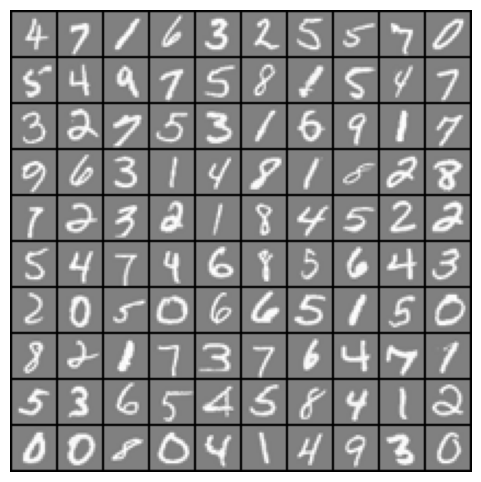

In [4]:
def displayData(X, example_width=20):
    plt.figure(figsize=(6, 6))
    m, n = X.shape
    example_height = n // example_width
    display_rows = int(np.sqrt(m))
    display_cols = m // display_rows
    
    pad = 1
    display_array = -np.ones((pad + display_rows * (example_height + pad),
                              pad + display_cols * (example_width + pad)))

    for i in range(display_rows):
        for j in range(display_cols):
            if i * display_cols + j >= m:
                break
            example = X[i * display_cols + j, :].reshape(example_height, example_width)
            display_array[pad + i * (example_height + pad):pad + i * (example_height + pad) + example_height,
                          pad + j * (example_width + pad):pad + j * (example_width + pad) + example_width] = example / np.max(example)

    plt.imshow(display_array.T, cmap='gray')
    plt.axis('off')
    plt.show()

# Display 100 random data points
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)


# Helper Functions

In [5]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost Function and Gradient with Regularization
def lrCostFunction(theta, X, y, lambda_):
    m = len(y)
    theta = theta[:, np.newaxis]
    y = y[:, np.newaxis]
    predictions = sigmoid(X @ theta)
    cost = -(1 / m) * (y.T @ np.log(predictions) + (1 - y).T @ np.log(1 - predictions))
    reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)
    cost = cost + reg_term

    grad = (1 / m) * (X.T @ (predictions - y))
    grad[1:] += (lambda_ / m) * theta[1:]
    return cost[0, 0], grad.flatten()

## Testing lrCostFunction() with regularization

In [6]:
# Test case for lrCostFunction
print('\nTesting lrCostFunction() with regularization')

theta_t = np.array([-2, -1, 1, 2], dtype=float)
X_t = np.hstack([np.ones((5, 1)), np.reshape(np.arange(1, 16), (5, 3), order='F') / 10])
y_t = (np.array([1, 0, 1, 0, 1]) >= 0.5).astype(float)
lambda_t = 3

# Calculate cost and gradient
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

# Print the results
print(f'\nCost: {J:.6f}')
print('Expected cost: 2.534819')
print('Gradients:')
print('\n'.join([f'{g:.6f}' for g in grad]))
print('Expected gradients:')
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003')



Testing lrCostFunction() with regularization

Cost: 2.534819
Expected cost: 2.534819
Gradients:
0.146561
-0.548558
0.724722
1.398003
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


# One-vs-All Training
# Train logistic regression classifiers for each digit

In [7]:
def oneVsAll(X, y, num_labels, lambda_):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    X = np.column_stack((np.ones(m), X))

    for i in range(num_labels):
        initial_theta = np.zeros(n + 1)
        label = (y == i).astype(int)

        # Define the cost function and gradient for this class
        cost_function = lambda t: lrCostFunction(t, X, label, lambda_)[0]
        gradient_function = lambda t: lrCostFunction(t, X, label, lambda_)[1]

        # Perform optimization
        # result = minimize(cost_function,
        #                   initial_theta,
        #                   jac=gradient_function,
        #                   options={'maxiter': 50})
        result = minimize(cost_function,
                          initial_theta,
                          jac=gradient_function,
                          method='L-BFGS-B',
                          options={'maxiter': 50})
        
        # Capture final iteration and cost
        final_iteration = result.nit
        final_cost = result.fun
        
        print(f"Training classifier for digit {i}... | Iteration {final_iteration} | Cost: {final_cost:.6f}")

        # Save the optimized theta for this class
        all_theta[i, :] = result.x
    
    return all_theta

lambda_ = 0.1
num_labels = 10

all_theta = oneVsAll(X, y, num_labels, lambda_)

Training classifier for digit 0... | Iteration 50 | Cost: 0.008609
Training classifier for digit 1... | Iteration 50 | Cost: 0.013156
Training classifier for digit 2... | Iteration 50 | Cost: 0.052786
Training classifier for digit 3... | Iteration 50 | Cost: 0.059056
Training classifier for digit 4... | Iteration 50 | Cost: 0.033672
Training classifier for digit 5... | Iteration 50 | Cost: 0.056022
Training classifier for digit 6... | Iteration 50 | Cost: 0.018521
Training classifier for digit 7... | Iteration 50 | Cost: 0.031207
Training classifier for digit 8... | Iteration 50 | Cost: 0.080192
Training classifier for digit 9... | Iteration 50 | Cost: 0.072486


## Predict with One-vs-All Classifier
## Predict the label for each example using trained classifiers

In [8]:
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    X = np.column_stack((np.ones(m), X))
    predictions = X @ all_theta.T
    return np.argmax(predictions, axis=1)

# Compute predictions and accuracy
pred = predictOneVsAll(all_theta, X)
accuracy = np.mean(pred == y) * 100

print(f"Training Set Accuracy: {accuracy:.2f}%")


Training Set Accuracy: 96.16%


## Optional analysis and some comments

### The original octave simulation achieved an accuracy of 95.04% for this problem. Using BFGS (the default method for scipy.minimize in this case), we achieved 93.24% accuracy. L-BFGS-B and Newton-CG achieved over 96%, whereas CG achieved over 95%. However, Newton-CG is too slow despite requiring fewer iterations.

### An interesting exercise is to modify the number of iterations and experiment with different optimization methods (refer to the documentation of scipy.minimize for available options).

# Neural Networks

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [11]:
data = loadmat('data/ex3data1.mat')
X = data['X']  # Features (400-dimensional vectorized images)
y = data['y'].flatten()  # Labels (1-10, with 10 representing '0')

In [12]:
# Map label '10' to '0'
y[y == 10] = 0
m = X.shape[0]  # Number of examples

# Load Neural Network Weights

In [13]:
# Load pre-trained weights from ex3weights.mat
weights = loadmat('data/ex3weights.mat')
Theta1 = weights['Theta1']  # Weights between input and hidden layer
Theta2 = weights['Theta2']  # Weights between hidden and output layer

# Visualize data

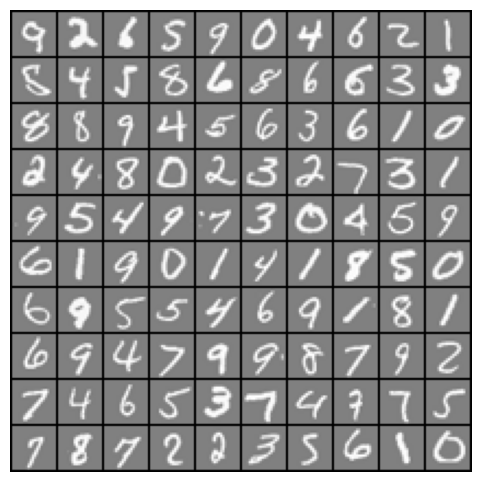

In [14]:
# Function to display data points as a grid of images

def displayData(X, example_width=20):
    plt.figure(figsize=(6, 6))
    m, n = X.shape
    example_height = n // example_width
    display_rows = int(np.sqrt(m))
    display_cols = m // display_rows
    
    pad = 1
    display_array = -np.ones((pad + display_rows * (example_height + pad),
                              pad + display_cols * (example_width + pad)))

    for i in range(display_rows):
        for j in range(display_cols):
            if i * display_cols + j >= m:
                break
            example = X[i * display_cols + j, :].reshape(example_height, example_width)
            display_array[pad + i * (example_height + pad):pad + i * (example_height + pad) + example_height,
                          pad + j * (example_width + pad):pad + j * (example_width + pad) + example_width] = example / np.max(example)

    plt.imshow(display_array.T, cmap='gray')
    plt.axis('off')
    plt.show()

# Display 100 random data points
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
displayData(sel)

# Neural Network Prediction

In [15]:
# Predict the label of an input given trained neural network weights

def predict(Theta1, Theta2, X):
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # Add bias unit to input layer
    X = np.column_stack((np.ones(m), X))

    # Hidden layer
    z2 = X @ Theta1.T
    a2 = sigmoid(z2)
    
    # Add bias unit to hidden layer
    a2 = np.column_stack((np.ones(a2.shape[0]), a2))

    # Output layer
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)

    # Prediction
    pred = np.argmax(a3, axis=1)

    # Adjust predictions
    pred += 1  # Convert from 0-based to 1-based indexing
    pred[pred == 10] = 0  # Map label 10 to 0
    return pred

# Predict using neural network
pred = predict(Theta1, Theta2, X)
accuracy = np.mean(pred == y) * 100

print(f"Training Set Accuracy: {accuracy:.2f}%")
print(f'Expected Training Set Accuracy: 97.52%')

Training Set Accuracy: 97.52%
Expected Training Set Accuracy: 97.52%


# Visualize Predictions

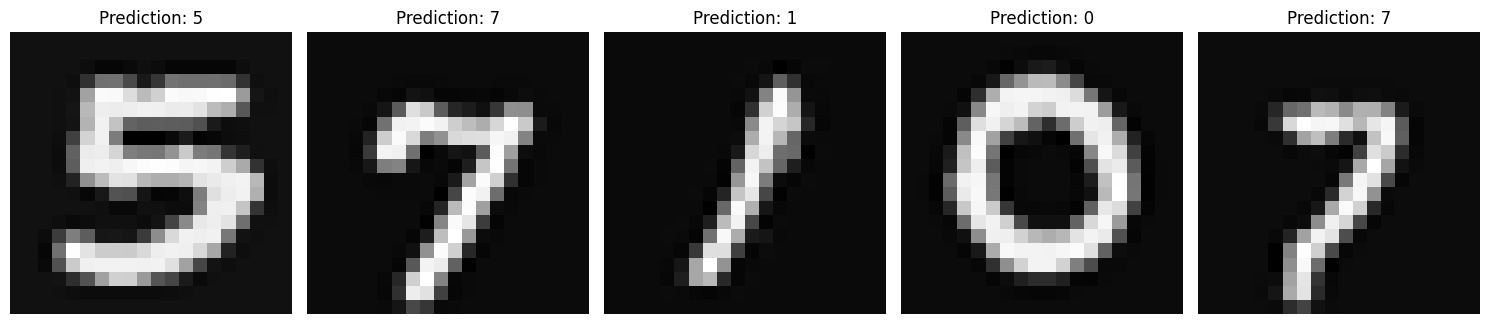

In [16]:
# Display predictions for random examples in a Jupyter Notebook
rp = np.random.permutation(m)

# Set up the number of examples to display
num_examples = 5

# Create a single figure to display all examples
fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))

for i in range(num_examples):
    ax = axes[i]  # Select the current subplot
    # Display Example Image
    ax.imshow(X[rp[i], :].reshape(20, 20).T, cmap='gray')
    ax.axis('off')  # Hide axis for cleaner display
    pred = predict(Theta1, Theta2, X[rp[i], :][np.newaxis, :])[0]
    ax.set_title(f"Prediction: {pred}", fontsize=12)

plt.tight_layout()
plt.show()